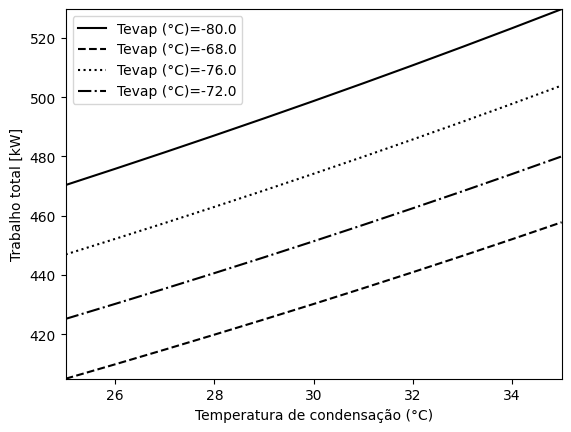

In [3]:
from CoolProp.CoolProp import PropsSI as COOLPROP
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#Listas
T1_lista = []
T9_lista = []
Wcomp_total_lista = []
COP_lista = []
cont = []

#temperaturas de condensação
for i in range (25, 36, 1):
    cont.append(i+273.15)

#Parâmetros
Pfrig = 120 * 1000 #[W]
T4 = -24 + 273.15 #[K]
T10 = -29 + 273.15 #[K]
fluid_high = 'R600'
fluid_low = 'R170'
N = 0.7
drop_suc = 1 #[Pa]
drop_desc = 0 #[Pa]
efet = 0.7 #efetividade do trocador intermediário
DeltaT = 0 #[°C]

#Pressão crítica do fluido do ciclo de alta pressão
P_crit_high = COOLPROP('PCRIT', fluid_high)

#Ciclo de baixa pressão
P4 = COOLPROP('P', 'T', T4, 'Q', 0, fluid_low)
P5 = P4
cp4 = COOLPROP('CP0MASS', 'T', T4, 'Q', 0, fluid_low)
h4 = COOLPROP('H', 'T', T4, 'Q', 0, fluid_low)

#Ciclo de alta pressão
P10 = COOLPROP('P', 'T', T10, 'Q', 0.3, fluid_high)
P7 = P10
h7 = COOLPROP('H', 'P', P10, 'Q', 1, fluid_high)
T7 = COOLPROP('T', 'P', P10, 'Q', 1, fluid_high)
hw = h7
Pw = P7 - drop_suc
Tw = COOLPROP('T', 'H', hw, 'P', Pw, fluid_high)
Px = Pw
Tx = Tw + DeltaT
hx = COOLPROP('H', 'P', Px, 'T', Tx, fluid_low)
sx = COOLPROP('S', 'P', Px, 'T', Tx, fluid_low)

#Variação das temperaturas de evaporação e condensação
for T1 in range (-80, -67, 4):
    #Ciclo de baixa pressão
    T1 = T1 + 273.15
    cp1 = COOLPROP('CP0MASS', 'T', T1, 'Q', 1, fluid_low)
    P1 = COOLPROP('P', 'T', T1, 'Q', 1, fluid_low)
    h1 = COOLPROP('H', 'T', T1, 'Q', 1, fluid_low)
    P2 = P1
    #Comparação entre os calores específicos nos pontos 4 e 1
    if cp1 < cp4:
        T2 = efet * (T4 - T1) + T1
        h2 = COOLPROP('H', 'T', T2, 'P', P2, fluid_low)
        ha = h2
        Pa = P2 - drop_suc
        Ta = COOLPROP('T', 'H', ha, 'P', Pa, fluid_low)
        Pb = Pa
        Tb = Ta + DeltaT
        hb = COOLPROP('H', 'P', Pb, 'T', Tb, fluid_low)
        sb = COOLPROP('S', 'P', Pb, 'T', Tb, fluid_low)
        P3 = P4
        Pc = P3 + drop_desc
        h5 = h4 + h1 - h2
        T5 = COOLPROP('T', 'H', h5, 'P', P5, fluid_low)
        h6 = h5
    else:
        T5 = T4 - efet * (T4 - T1)
        h5 = COOLPROP('H', 'T', T5, 'P', P5, fluid_low)
        h2 = h4 + h1 - h5
        T2 = COOLPROP('T', 'H', h2, 'P', P2, fluid_low)
        ha = h2
        Pa = P2 - drop_suc
        Ta = COOLPROP('T', 'H', ha, 'P', Pa, fluid_low)
        Pb = Pa
        Tb = Ta + DeltaT
        hb = COOLPROP('H', 'P', Pb, 'T', Tb, fluid_low)
        sb = COOLPROP('S', 'P', Pb, 'T', Tb, fluid_low)
        P3 = P4
        Pc = P3 + drop_desc
        h6 = h5
    m_flow_low = Pfrig / (h1 - h6)
    P3 = P4
    Pc = P3 + drop_desc
    sc_ideal = sb
    hc_ideal = COOLPROP('H', 'P', Pc, 'S', sc_ideal, fluid_low)
    hc_real = (hc_ideal - hb)/N + hb
    h3 = hc_real
    #Trabalho específico do compressor do ciclo de baixa pressão
    w_low = hc_real - hb
    #Trabalho do compressor do ciclo inferior
    Wcomp_low = m_flow_low * w_low
    #Calor trocado no trocador central
    Qcond_low =  m_flow_low * (h3 - h4)
    for T9 in cont:
        #Ciclo de alta pressão
        P9 = COOLPROP('P', 'T', T9, 'Q', 0, fluid_high)
        P8 = P9
        Py = P8 + drop_desc
        sy_ideal = sx
        hy_ideal = COOLPROP('H', 'P', Py, 'S', sy_ideal, fluid_high)
        hy_real = (hy_ideal - hx)/N + hx
        Py = P8 + drop_desc
        h9 = COOLPROP('H', 'T', T9, 'Q', 0, fluid_high)
        h10 = h9
        Qevap_high = Qcond_low
        m_flow_high = Qevap_high / (h7 - h10)
        #Verificação da pressão crítica
        if P_crit_high > P8:
            T1_lista.append(T1 - 273.15)
            T9_lista.append(T9 - 273.15)
            #Registro dos graus de subresfriamento e superaquecimento
            grau_subresf = T4 - T5
            grau_superaq = T2 - T1         
            #print('O grau de subresfriamento (T1 = {:0.2f}°C, T9 = {:0.2f}°C) é igual a {:0.2f}°C.'.
                  #format(T1-273.15, T9-273.15, grau_subresf))
            #print('O grau de superaquecimento (T1 = {:0.2f}°C, T9 = {:0.2f}°C) é igual a {:0.2f}°C.'.
                  #format(T1-273.15, T9-273.15,grau_superaq))
            #Trabalho específico do compressor do ciclo de alta pressão
            w_high = hy_real - hx
            #Trabalho do compressor do ciclo superior
            Wcomp_high = m_flow_high * w_high
            #Trabalho total do ciclo
            Wcomp_total = Wcomp_high + Wcomp_low
            Wcomp_total_lista.append(Wcomp_total / 1000)
            #COP
            COP = Pfrig / Wcomp_total
            COP_lista.append(COP)
        else:
            print ('A pressão P8 = {:0.2f} kPa (T1 = {:0.2f}°C, T9 = {:0.2f}°C) é maior do que a ' 
               'pressão crítica do {} logo o ponto não foi incluído no gráfico'
                   .format(P8/1000,T1-273.15,T9-273.15,fluid_high))         


   
x = T9_lista
z = T1_lista
y = Wcomp_total_lista

# Define um dicionário que mapeia os valores de z para estilos de linha diferentes
z_linestyles = {z_val: linestyle for z_val, linestyle in zip(set(z), ['-','--', ':', '-.'])}

# Cria uma figura com um gráfico 2D
fig, ax = plt.subplots()

# Itera sobre os valores únicos de z
for z_val in set(z):
    # Seleciona os pontos correspondentes a z_val
    x_val = [x[i] for i in range(len(x)) if z[i] == z_val]
    y_val = [y[i] for i in range(len(y)) if z[i] == z_val]

    # Plota os pontos com uma linha ligando eles
    ax.plot(x_val, y_val, linestyle=z_linestyles[z_val], color='black', label=f'Tevap (°C)={z_val}')

# Define os limites dos eixos X e Y
ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))

# Define os rótulos dos eixos X e Y
ax.set_xlabel('Temperatura de condensação (°C)')
ax.set_ylabel('Trabalho total [kW]')

# Adiciona a legenda
ax.legend()


# Mostra o gráfico
plt.show()

